Case 1 - Heart Disease Classification
=====================================
Henrik Hokkanen, Simo Mäkelä  
31.1.2020  
Neural Networks for Health Technology Applications  
Helsinki Metropolia University of Applied Sciences

Introduction
------------

In this exercise, the aim is to create and train a dense neural network to predict the presence of heart disease using the dataset at https://archive.ics.uci.edu/ml/datasets/Heart+Disease

In [540]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from scipy.signal import savgol_filter

Dataset
-------

Let's load the UCI Heart Disease dataset and look further into its features.

The Cleveland database used here is a subset of this dataset. It has 14 attributes, contains 303 samples, and is commonly used in machine learning experiments. The presence of heart disease is distinguished by values 1, 2, 3 and 4. Value 0 denotes the absence of heart disease. It is not specified in the dataset documentation, which medical conditions are considered encompassed by "heart disease". The assumption is that coronary artery disease is the prevailing diagnosis in this data.

In [541]:
url = r'http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
col_names = ['age','sex','cp','trestbps','chol','fbs','restecg','thalac','exang','oldpeak','slope','ca','thal','num']
df = pd.read_csv(url, 
                 sep = ',', 
                 header = None, 
                 index_col = None,
                 names = col_names,
                 na_values = '?')
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalac,exang,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


Above is a summary containing statistical key figures of the dataset in use. The data is loaded into a pandas data frame.

Let's print a few key figures and make a quick histogram visualization of the data to get an idea of what we're dealing with.

Data size: 303 rows, of which 6 (2.0 %) contain empty values.
Healthy: 164 (54.1 %) Diseased: 139 (45.9 %)


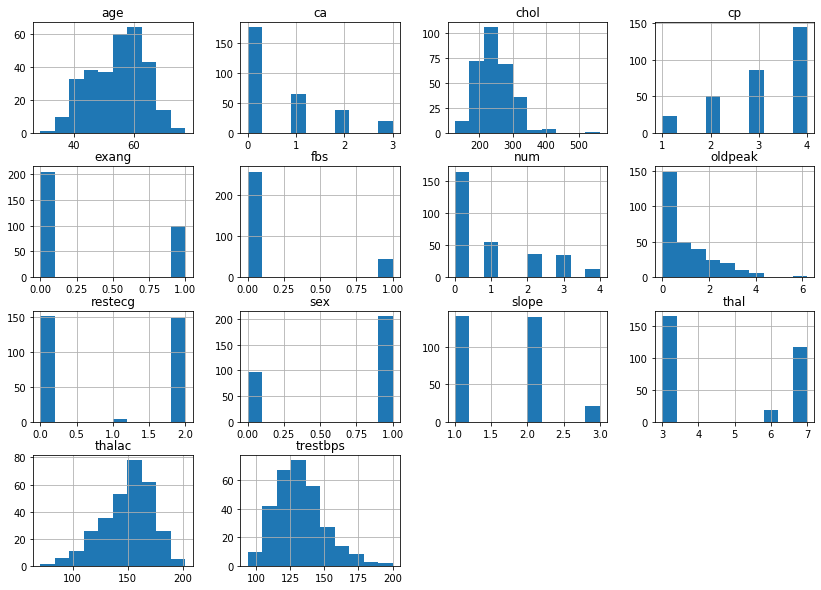

In [542]:
data_size = df['num'].count()

empty = df.isna().sum().sum()
empty_p = (empty / data_size) * 100 # percentage

diseased = df['num'][df['num'] > 0].count()
diseased_p = (diseased / data_size) * 100 # percentage

healthy = data_size - diseased
healthy_p = (healthy / data_size) * 100 # percentage

print("Data size: %d rows, of which %d (%3.1f %%) contain empty values." %(data_size, empty, empty_p))
print("Healthy: %d (%3.1f %%) Diseased: %d (%3.1f %%)" %(healthy, healthy_p, diseased, diseased_p))

fig = df.hist(figsize=(14,10))

In [543]:
# define a helper function to visualize each column.
def plot_attribute(name):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
    fig.suptitle(name, fontsize=16)
    # histogram left
    df[name].hist(ax = axes[0], color='green')
    # box plot right - this may help spot outliers.
    df[name].plot(ax = axes[1], kind='box', color="magenta")
    plt.show()

Attribute Description
---------------------

Now we will describe each attribute in more detail and consider their significance. We will also decide for each column, if they should be excluded from the analysis.

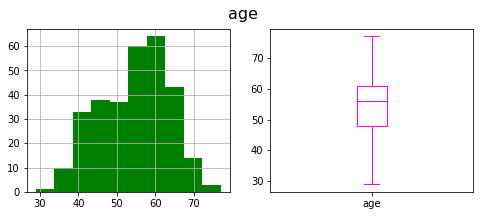

min: 29.0 max: 77.0


In [544]:
plot_attribute('age')
print("min:", df['age'].min(), "max:", df['age'].max())

__Patient age__ in years. Increasing age is recognized as a major risk factor for coronary disease by American Heart Association.

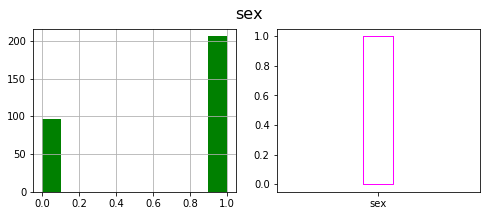

Males: 206 Females: 97


In [545]:
plot_attribute('sex')
print("Males:", len(df['sex'][df['sex']==1]), "Females:", len(df['sex'][df['sex']==0]))

Value 1 denotes male __sex__. Male sex is recognized as a major risk factor for coronary disease by American Heart Association. A binary categorical variable.

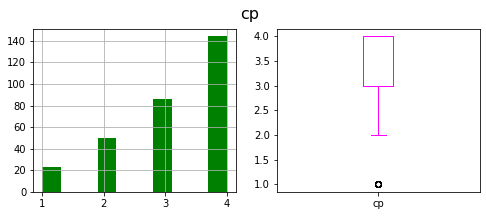

In [546]:
plot_attribute('cp')

__Chest pain type.__ This is a categorical variable. Individuals without pain are in category 4. Categories 1, 2 and 3 denote "typical", "atypical" and "non-anginal" pain, respectfully:

- 1 Typical
- 2 Atypical
- 3 Non-anginal
- 4 Asymptomatic

The severities of categories 1 to 4 perhaps bear an ordinal relationship, where value 1 is the most alarming and value 4 is the least alarming. An ordinal scale variable can probably be scaled safely. Then again, one-hot encoding it into four separate columns would probably be best.

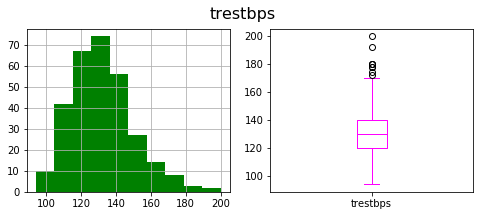

In [547]:
plot_attribute('trestbps')

__Resting blood pressure__ on admission. Judging by the values, this is the systolic blood pressure. High blood pressure is recognized as a major risk factor for coronary disease by American Heart Association.

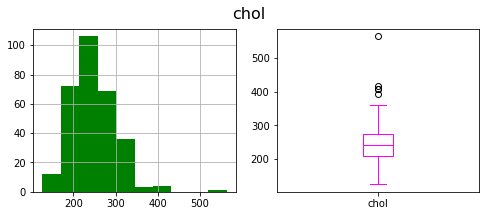

In [548]:
plot_attribute('chol')

__Serum cholesterol__ in mg/dl. High blood cholesterol is recognized as a major risk factor for coronary disease by American Heart Association.

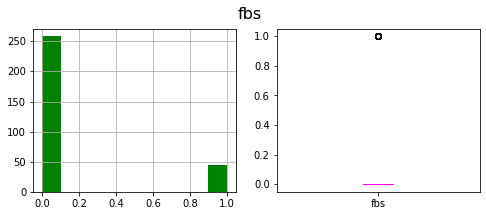

In [549]:
plot_attribute('fbs')

High __fasting blood glucose__. A categorical variable, where value 1 denotes glucose reading above 120 mg/dl, otherwise 0.

Diabetes, uncontrolled or not, is recognized as a major risk factor for coronary disease by American Heart Association.

As we later examine the correlation table, we will see that __fbs__ has almost no correlation to heart disease, so we choose to exclude this feature for the sake of model simplicity.

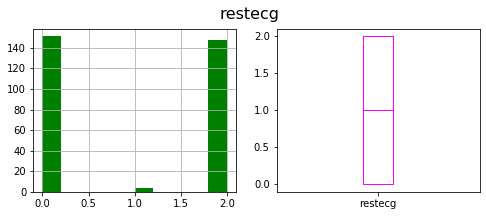

In [550]:
plot_attribute('restecg')

__ECG findings__, patient at rest.

- 0 denotes no findings
- 1 denotes abnormality in ST-T waveform
- 2 denotes a finding characteristic to a condition called left ventricular hypertrophy.

This categorical variable is of a nominal scale, i.e. there is no order between the values, or at least interpreting such order would be highly subjective. This is because both findings have unique diagnostic value. One-hot encoding it into three separate columns should be done. 

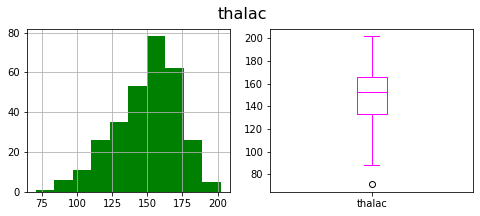

In [551]:
plot_attribute('thalac')

__Maximum heart rate achieved__ during thallium-201 scintigraphy stress test. This variable should have a negative correlation to heart disease, as a young and healthy heart can beat faster than a sick and old one.

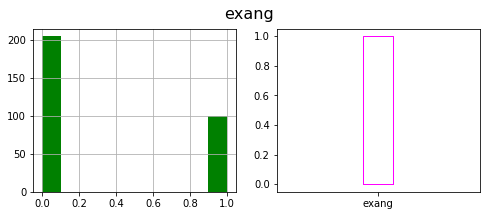

In [552]:
plot_attribute('exang')

__Exercise-induced angina.__ Chest pain provoked by physical exertion _may_ be a sign of coronary artery disease.

This is a categorical variable:

- 1 Yes
- 2 No

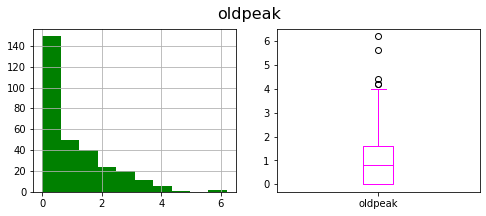

In [553]:
plot_attribute('oldpeak')

__Exercise-induced ST-level depression__ in ECG. Assumedly the unit of this variable is millimeters.

Exertion testing can reveal coronary disease through demand ischemia and a subsequent ECG finding.

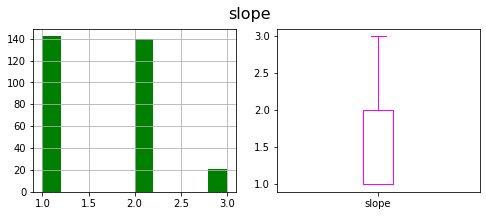

In [554]:
plot_attribute('slope')

__Slope of the peak exercise ST segment.__ A categorical variable:

- 1 upsloping
- 2 flat
- 3 downsloping

ST slope is a marker of transient myocardial ischemia. An ordinal variable ranging from the least alarming 1 to the most alarming 3. Should be safely scalable.

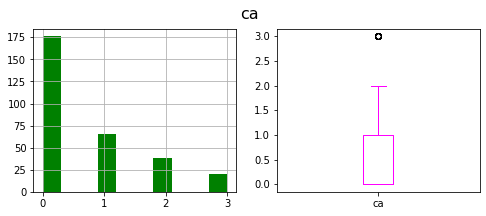

In [555]:
plot_attribute('ca')

__Number of major vessels__ (fluoroscopy). Assumedly, this is coronary calcification detected in fluoroscopic angiography in any three of the main vessels.

- 0 No findings
- 1 One major coronary vessel impacted
- 2 Two major coronary vessels impacted
- 3 Three major coronary vessels impacted

This column contains a few empty values.

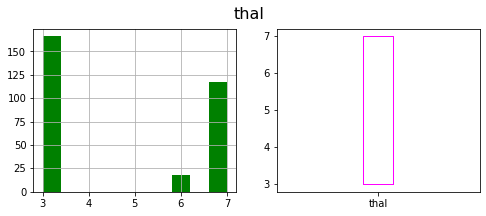

In [556]:
plot_attribute('thal')

__Thallium-201 stress scintigraphy results.__

- 3 Normal
- 6 Fixed defect
- 7 Reversable defect

Reversible defect during exertion test is a sign of poor perfusion. A fixed (permanent) defect implies old myocardial infarction.

This column contains a few empty values. This categorical variable should be one-hot encoded.

Preprocessing
-------------

scale or normalize the variables  
replace missing values with zeros, means/medians or random values

__Imputation (handling of empty values)__

There are six samples in the dataset containing empty values. This represents only 2 % of all the records, as mentioned earlier. The empty values occur in columns `ca` and `thal`, which are both problematic when it comes to inventing meaningful substitute data. Both are categorical variables containing actual clinical results, so all kinds of mean/interpolation methods will probably just create distortion and error. Therefore we choose to do listwise deletion, eliminating incomplete samples entirely.

In [557]:
# eliminate incomplete data
df = df.dropna()

__Splitting the Data__

We now split the data into two sets, setting aside 20 percent of it in a test set. The __test set__ will only be used for final model performance evaluation, and its contents shall not be exposed to the model development process in any way.

The rest 80 % of the data will be used for training and validation. The data split is done following the 60-20-20 rule introduced in class.

In [558]:
df['num'] = (df['num'] > 0) * 1.0  # convert output labels to zeros and ones
train_data, test_data = np.split(df, [int(.8 * len(df)),])

Now that data has been split, let's examine if these subsets are actually representative of the entire data. We want both training and testing sets to contain both sick and healthy individuals in roughly the same proportion as the whole dataset.

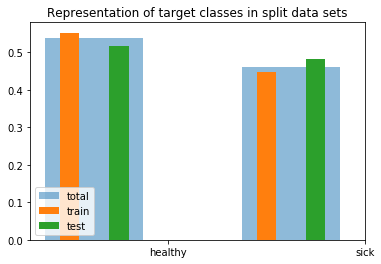

In [559]:
train_counts = train_data['num'].value_counts()
test_counts = test_data['num'].value_counts()
total_counts = train_counts + test_counts
categories = train_data['num'].unique()

plt.bar(categories+0.125, total_counts / df['num'].count(), width=0.5, alpha=0.5)
plt.bar(categories, train_counts / train_data['num'].count(), width=0.1)
plt.bar(categories+0.25, test_counts / test_data['num'].count(), width=0.1)
plt.legend(['total', 'train', 'test'], loc=3)
plt.xticks([0.5, 1.5], labels=['healthy', 'sick'])
plt.title('Representation of target classes in split data sets')

plt.show()

Target class distribution seems fine in both subsets. Total sick-healthy-distribution is close to 50:50, which suggests, that _accuracy_ will be a useful metric when evaluating the model.

__Scaling__

There are many ways to scale the data to even out each attribute's effect on the model. We could normalize it by subtracting mean and dividing by standard deviation, or standardize it by scaling its range down to -1...1. Both of these methods behave badly with outliers, compressing the inliers into a narrow range. Using sklearn's `RobustScaler` mitigates this problem.

The scaling parameters are fitted to the training/validation set. The training set and test set are both then scaled using these parameters.

In [560]:
# set aside output labels, while scaling input data
train_num = train_data['num'].values
test_num = test_data['num'].values

# using the RobustScaler that was advertised on Wednesday's lecture
scaler = RobustScaler()
# fit scaler parameters to the training/validation set and scale it
train_data = pd.DataFrame(scaler.fit_transform(train_data))
train_data.columns = col_names
# scale the test set using the same parameters
test_data = pd.DataFrame(scaler.transform(test_data))
test_data.columns = col_names

# replace original target labels
train_data['num'] = (train_num > 0) * 1.0
test_data['num'] = (test_num > 0) * 1.0

Feature Selection
-----------------

Let's see how our input variables correlate to being affected by a heart disease. Correlation may suggest whether or not an input variable is useful or not. There are also other methods of gauging feature importance. Plain correlation is by no means a perfect measure of feature importance.

In [561]:
train_data.corr()['num']

age         0.250104
sex         0.272576
cp          0.448295
trestbps    0.156313
chol        0.112987
fbs        -0.026038
restecg     0.197816
thalac     -0.457597
exang       0.433948
oldpeak     0.415809
slope       0.353332
ca          0.449147
thal        0.525390
num         1.000000
Name: num, dtype: float64

Let's filter the desired columns from the dataframe and separate the input data from output labels.

We eliminate from the analysis `fbs`, because it seems to have no correlation to heart disease. Also eliminating `restecg` and `thal`, because they would require one-hot encoding to be meaningful. This leaves us with ten input arguments.

In [562]:
selected_features = ['age', 'sex', 'cp', 'trestbps', 'chol', 'thalac', 'exang', 'oldpeak', 'slope', 'ca']
# input
train_X = train_data.filter(selected_features)
test_X = test_data.filter(selected_features)
# output
train_y = train_data.filter(['num'])
test_y = test_data.filter(['num'])

Model
-----

Next, we will construct a feed-forward neural network to predict heart disease. We experiment by adjusting hyperparameters like number of layers, number of neurons, choice of optimizer and its learning rate, activation function, dropout, regularization, batch size and number of epochs.

We will inspect the learning curves to detect overfitting, maximize accuracy and minimize loss. Based on the learning curve, we choose a good number of epochs for early stopping.

While iteratively improving our model, we employ 20 % of the data set (25 % of the training set) for validation. This allows us to detect overfitting. Diverging learning curves for training and validation is a sign of overfitting.

We use [this material from Stanford cs231n course](http://cs231n.github.io/neural-networks-3/#baby) as a guideline for adjusting hyperparameters like learning rate and model complexity.

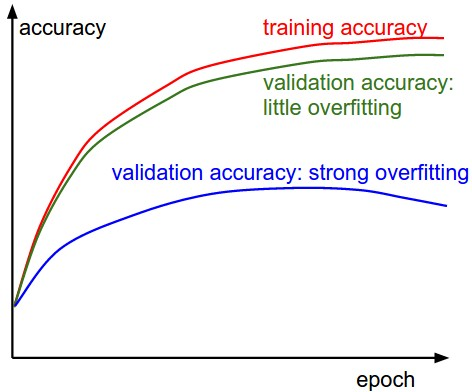

_"The gap between the training and validation accuracy indicates the amount of overfitting." Source: Stanford University_

In this case we can, for example, add regularization, decrease model complexity or add dropout.

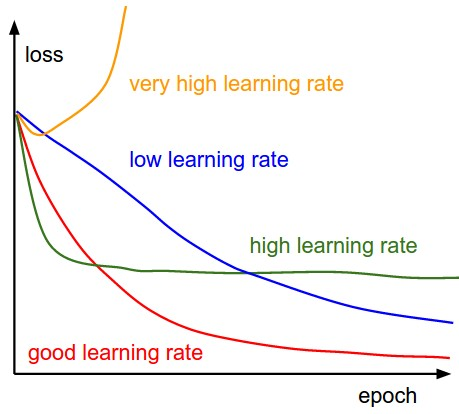

_"With low learning rates the improvements will be linear. With high learning rates they will start to look more exponential. Higher learning rates will decay the loss faster, but they get stuck at worse values of loss (green line)." Source: Stanford University_

In [563]:
def create_model():
    reg = tf.keras.regularizers.l2(0.002)
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(13, activation='sigmoid', kernel_regularizer=reg, input_shape=(train_X.shape[1],)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(6, activation='sigmoid', kernel_regularizer=reg),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    opt = tf.keras.optimizers.RMSprop(lr=0.001)

    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

batch_size = 30
epochs = 300

In [564]:
model = create_model()
#print(model.summary())

In [565]:
history = model.fit(np.asarray(train_X),
                    np.asarray(train_y),
                    verbose=0,
                    batch_size=batch_size,
                    validation_split=0.25,
                    epochs=epochs)

In [566]:
model.evaluate(np.asarray(train_X), np.asarray(train_y), verbose=2)

237/1 - 1s - loss: 0.3514 - accuracy: 0.8692


[0.42446552210719274, 0.8691983]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


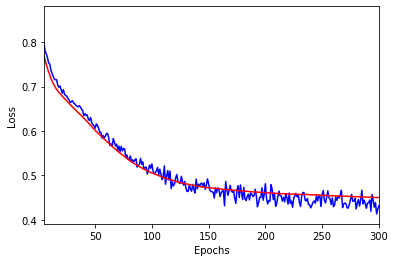

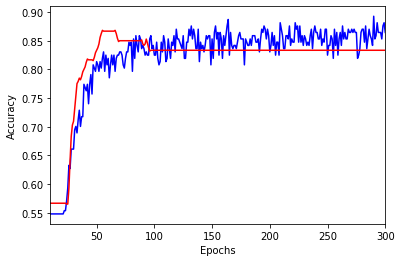

In [567]:
# plot loss and accuracy learning curves for training and validation sets

print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

time = range(1,len(loss)+1)

plt.plot(time, loss, 'b-')
plt.plot(time, val_loss, 'r-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim((5,epochs))
plt.show()

plt.plot(time, acc, 'b-')
plt.plot(time, savgol_filter(val_acc, 5, 3), 'r-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim((10,epochs))
plt.show()

<span style="color:red">The code from this point on should only be used in final evaluation</span>
--------------------------------------------------------------------------------------------------
If we run this code __and__ make modifications to the model based on its results, information will leak from the test set into our model. We have tucked away the test set to do final testing with data previously unseen to our model, and taken measures to prevent data leakage at any point in development.

A steady stream of fresh data would eliminate the need to guard this test set so closely.

Final Evaluation
----------------
Next, we create a fresh model and retrain it from scratch, now using the entire training set without reserving data for validation. Then we evaluate the model against the previously unseen test set to see how well it actually performs.

If we see much poorer performance (accuracy) here, compared to training and validation, our model is probably overfitted, i.e. it has become an expert in reciting the training/validation set, but gets confused when encountering unseen samples.

In [568]:
# create a fresh model for final evaluation
model = create_model()
# train model with early stopping based on learning curve, to avoid overfitting
# use all data: no validation set
_ = model.fit(np.asarray(train_X), np.asarray(train_y), verbose=0, batch_size=batch_size, epochs=170)

In [569]:
loss, acc = model.evaluate(np.asarray(test_X), np.asarray(test_y), verbose=0)
print("loss:", loss, "accuracy:", acc)

loss: 0.5868688106536866 accuracy: 0.75


Results
-------
Let's use various __metrics__ to gain insight into our model's performance.

In [570]:
y_pred = np.array(model.predict(np.asarray(test_X))).flatten()
target_names = ['Healthy', 'Sicko']
print(classification_report(test_y, y_pred.round(), target_names=target_names))

              precision    recall  f1-score   support

     Healthy       0.69      0.86      0.77        29
       Sicko       0.83      0.65      0.73        31

    accuracy                           0.75        60
   macro avg       0.76      0.75      0.75        60
weighted avg       0.77      0.75      0.75        60



The __classification report__ shows accuracy, precision, recall and f1-score.

In [571]:
confusion_matrix(test_y, y_pred.round()).T

array([[25, 11],
       [ 4, 20]], dtype=int64)

This __confusion matrix__ contains the following values:

    true positives    false positives
    false negatives   true negatives

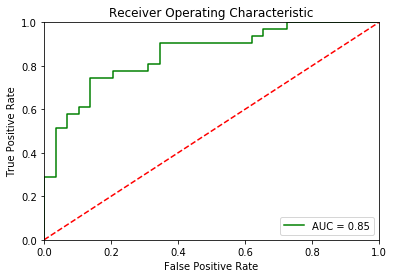

In [572]:
# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(np.asarray(test_X))
preds = probs[:,0]
fpr, tpr, threshold = roc_curve(test_y, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', color='green', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The __ROC curve__ plots true positive rate against false positive rate at different discrimination thresholds. A high AUC (Area Under Curve) is a measure of good model performance.

The ROC curve should travel as close to upper left corner as possible.

Let's compare our model's predictions to actual truth. It is interesting to see the "certainty" of false and successful predictions. This certainty value is calculated using the network's output, which ranges from 0 to 1.

In [573]:
y_pred_labels = np.array(y_pred.round()).flatten()
y_percent = np.abs((y_pred - 0.5)) * 2 * 100
pred = pd.DataFrame()
pred['Actual'] = np.asarray(test_y).flatten().astype(int)
pred['Prediction'] = y_pred_labels.astype(int)
pred['Sigmoid Output'] = y_pred.round(3)
pred['Certainty (%)'] = y_percent.astype(int)
pred

,Actual,Prediction,Sigmoid Output,Certainty (%)
0,0,0,0.090,82
1,0,0,0.077,84
2,0,0,0.139,72
3,1,0,0.455,9
4,0,0,0.144,71
5,1,1,0.807,61
6,1,0,0.405,19
7,1,1,0.846,69
8,1,1,0.707,41
9,0,0,0.105,79


Conclusions
-----------
Designing a viable ANN classifier is tedious work for an inexperienced novice.